# Set Variables

In [ ]:
# -------- dataset
# software_name = "Camel"
# software_name = "CloudStack"
# software_name = "Geode"
software_name = "Hbase"

In [ ]:
dataset_file_names = {
    "Camel":      "Camel_DE - v.02",
    "CloudStack": "CloudStack_DE - v.01",
    "Geode":      "Geode_DE - v.01",
    "Hbase":      "Hbase_DE - v.01"
}

dataset_file_name = dataset_file_names[software_name]

# Google Colab

In [ ]:
# Libs
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load data from google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
!ls "/content/gdrive/My Drive/"

Mounted at /content/gdrive
'Colab Notebooks'


In [ ]:
# project folder path
project_folder = "gdrive/MyDrive/Colab Notebooks/paper/"

# data folder path
data_folder =    "00- My Data/one-phase method/"

# output folder path
output_folder =  "01- Jupyter Notebook/50- one-phase method _ CNN/00. Output/"

In [ ]:
# dataset folder path
dataset_folder = software_name + "/"

# Libs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms

# Config

In [ ]:
mypaths = {
    "data": {
        "dataset": project_folder + data_folder + dataset_folder + dataset_file_name + ".csv"
    }
}

preprocessing_params = {
    "data":{
        "dataset": {
            "columns_name":   ["text", "bug_class_2"],
            "columns_dtype" : {0: "str", 1: "int64"},
            "bug_classes": [0, 1]
        },
    }
}

# I. Read Files

In [ ]:
df_main = pd.read_csv(
    mypaths["data"]["dataset"], 
    names=preprocessing_params["data"]["dataset"]["columns_name"], 
    dtype=preprocessing_params["data"]["dataset"]["columns_dtype"],
    header=None, 
    skip_blank_lines=True
)

# II. Compose

In [ ]:
class Rows(object):
    def __init__(self, columns_name, bug_classes):
        self.columns_name = columns_name
        self.bug_classes = bug_classes
    
    
    def __call__(self, df):
        # 1. Set cells to None that have just white spaces
        df = df.apply(self.white_spaces_to_None_, axis=1)
        
        # 2. Delete rows that have NaN values in each of its columns
        df.dropna(axis=0, how="any", subset=self.columns_name, inplace=True)
        
        # 3. Delete rows with class value other than [0, 1]
        indexNames = df[~df["bug_class_2"].isin(self.bug_classes)].index
        df.drop(indexNames, axis=0, inplace=True)
        
        return df
    
    
    # set columns that just have white spaces to None
    def white_spaces_to_None_(self, row):
        for i in self.columns_name:
            if row[i] and len(str(row[i]).strip()) == 0:
                row[i] = None
        return row

## obj

In [ ]:
composed_pre = transforms.Compose([
    Rows(
        preprocessing_params["data"]["dataset"]["columns_name"], 
        preprocessing_params["data"]["dataset"]["bug_classes"]
    )
])

df_main = composed_pre(df_main)

In [ ]:
print(len(df_main))

9201


# III. ClassDistribution
In order to see whether dataset is `imbalance` or not.

In [ ]:
class ClassDistribution():
    def __init__(self, class_distributions):
        self.num_samples = sum(class_distributions.values())
        self.class_distributions = class_distributions # {"class0": num0, "class1": num1, ...}
        self.ratios = {} # {"1/0": ratio1, "1/2": ratio2, ...}
        self.percentage = {} # {"class0": perc0, "class1": perc1, ...}
    
    
    def calc_ratios(self):
        mydata_sorted = [(key, value) for key, value in sorted(self.class_distributions.items(), 
                                                               key=lambda item: item[1], reverse=True)]
        num_classes = len(self.class_distributions)
        for i in range(num_classes - 1):
            for j in range(i + 1, num_classes):
                tempKey1 = mydata_sorted[i][0]
                tempKey2 = mydata_sorted[j][0]
                mykey = tempKey1 + "/" + tempKey2
                
                tempValue1 = mydata_sorted[i][1]
                tempValue2 = mydata_sorted[j][1]
                self.ratios[mykey] = tempValue1 / tempValue2
    
    def calc_percentage(self):
        for key, value in self.class_distributions.items():
            tempPerc = (value * 100) / self.num_samples
            tempPerc = round(tempPerc)
            tempPerc = str(tempPerc) + "%"
            self.percentage[key] = tempPerc
    
    
    def plot_data(self, dataName):
        myclasses = list(self.class_distributions.keys())
        num_bugreports_perclass = list(self.class_distributions.values())

        fig, ax = plt.subplots(1, figsize=(5, 3))
        
        ax.bar(myclasses, num_bugreports_perclass, color ="maroon", label="Bug Reports", width=0.4)
        ax.set_xlabel("classes")
        ax.set_ylabel("Number of bug reports")
        ax.legend()
        ax.set_title("Number of bug reports PER classes [{}]".format(dataName))

        fig.tight_layout()

## obj

ratios     :  {'0/1': 2.0098135426889105}
percentages:  {'0': '67%', '1': '33%'}


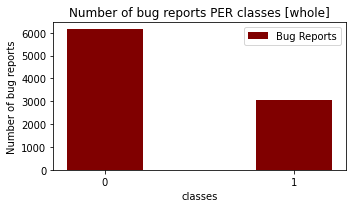

In [ ]:
cds = {} # {"train": {"class0": num0, "class1": num1, ...}, "validation": {...}, ...}
# calculate class distribution for whole dataset
temp = df_main.groupby("bug_class_2").size()
cd_whole = temp.to_dict()
cd_whole = {str(key): value for key, value in cd_whole.items()}
cds["whole"] = cd_whole

# plot class distribution for whole dataset
wholeCD = ClassDistribution(cd_whole)
wholeCD.calc_ratios()
print("ratios     : ", wholeCD.ratios)
wholeCD.calc_percentage()
print("percentages: ", wholeCD.percentage)
wholeCD.plot_data("whole")